In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from lib import evaluations
import matplotlib.pyplot as plt
import numpy as np

In [3]:
t= np.ones(64)*10
s= np.ones(64)*4

np.max((t,s))

10.0

In [4]:
def plot_kf_traj(pred, actual, sigma, start=0):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    
    x_max = pred[start:, 0] +sigma[start:, 0,0]
    y_max = pred[start, 0] + sigma[start:, 0,0]
    
    vmax = np.max((x_max, y_max)) + 0.5
    
    x_min = pred[start:, 0]  -sigma[start:, 1,1]
    y_min = pred[start, 0] - sigma[start:, 1,1]
    
    vmin = np.min((x_min, y_min)) - 0.5
    
    for j in range(state_dim):
        plt.figure(figsize=(8, 6))


        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Predicted"
        actual_label_arg['label'] = "Ground Truth"
        plt.plot(range(timesteps-start),
                 pred[start:, j],
#                      c=color(0),
                 **predicted_label_arg)
        plt.plot(range(timesteps-start),
                 actual[start:, j],
#                      c=color(1),
                 **actual_label_arg)

        conf_min = pred[start:, j] - np.sqrt(sigma[start:, j, j]) 
        conf_max = pred[start:, j] + np.sqrt(sigma[start:, j, j])
        plt.fill_between(range(timesteps-start), 
                         conf_min, conf_max, 
                         alpha=0.5)

        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))

        plt.title(f"State #{j} ")
        plt.xlabel("Timesteps")
        plt.ylabel("Value")
#             plt.legend()
#             plt.ylim(-2, 2)
        plt.ylim(vmin, vmax)
        plt.show()


In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

def draw_2d(ax, covariance, mean):
    E, V = np.linalg.eig(covariance)

    angle = np.arctan2(V[0,0], V[0,1]) / np.pi * 180.0
    el = Ellipse(xy=mean, width=2*np.sqrt(E[1]*5.99), height=2*np.sqrt(E[0]*5.99), angle=angle,
                 color='g', alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
    ax.add_artist(el)

def eval_2d_rollout(predicted_states,  actual_states,  covariance, contact_states,plot=True, plot_traj=None, start=0, ):
    contact = np.argmax(contact_states)
    print(contact)
    intervals = int((predicted_states.shape[0]-1 -contact)/4.0)
    print(intervals)
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[0]-1]
    
    if plot:
        timesteps = len(actual_states[0])

        def color(i):
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            return colors[i % len(colors)]

        state_dim = actual_states.shape[-1]
        
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(20,10))
        axes = axes.ravel()
        
        pred = predicted_states
        actual = actual_states
        sigma= np.sqrt(covariance)
        
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            draw_2d(ax, covariance[start+t], predicted_states[start+t])
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')

            ax.plot(pred[start:, 0],
                     pred[start:, 1],
                     c='b', alpha=0.4)
            ax.plot(actual[start:, 0],
                     actual[start:, 1],
                     c='orange', alpha=0.4)

            rmse = np.sqrt(np.mean(
                (predicted_states[:, start:] - actual_states[:, start:]) ** 2))

            x_max = np.max(pred[start:, 0] + sigma[start:, 0,0]) + 0.5
            y_max = np.max(pred[start:, 1] + sigma[start:, 1,1])+ 0.5
        
            x_min = np.min(pred[start:, 0]  - sigma[start:, 0,0])- 0.5
            y_min = np.min(pred[start:, 1] - sigma[start:, 1,1])- 0.5
            
            max_diff = np.max((x_max-x_min, y_max-y_min))
            
            x_max = x_min + max_diff
            y_max = y_min + max_diff
            
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title("Time: {}".format(t))

            if t >= contact:
                ax.set_title("Contact Made. Time: {}".format(t))
        
            ax.set_xlabel("X")

#         plt.title(f"x vs. y // RMSE = {rmse}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    return plot_times

In [6]:
def img_obs(trajectory, plot_times):
    #get image
    s, observations, controls = trajectory
    fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,10))
    axes = axes.ravel()
    for n, t in enumerate(plot_times): 
        ax = axes[n]
        ax.imshow(observations['image'][t][::-1,...], cmap='gray')
        ax.set_title("Timestep: {}".format(t))

In [7]:
plot_times=[0,0]
from lib import dpf, panda_models, panda_datasets, panda_kf_training, omnipush_datasets

for i in range(2):
    plot_times[i]= eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], plot=False)

print(plot_times)

eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_1000.hdf5", 100))

for i in range(2):
    img_obs(eval_trajectories[i], plot_times[i])

NameError: name 'predicted_states' is not defined

In [15]:
name = "ekfmixed_measmixed_Q"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, learnable_Q=True)
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))



[buddy-ekfmixed_measmixed_Q] Using device: cuda
[buddy-ekfmixed_measmixed_Q] Loaded metadata: {'batch': 128, 'ekf_loss': 'mixed', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'measurement_loss': 'mixed', 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmixed_measmixed_Q] Available checkpoint labels: ['0000000000045334', '0000000000047557', '0000000000048122', '0000000000048701', '0000000000048875', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[Trajec


rsme x: 
0.12150445482430819 
 y:
0.208356489873239
Sigma average:  [[ 3.6894784e-03 -5.1340921e-05]
 [-5.1340921e-05  4.3671383e-03]]


183
13


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


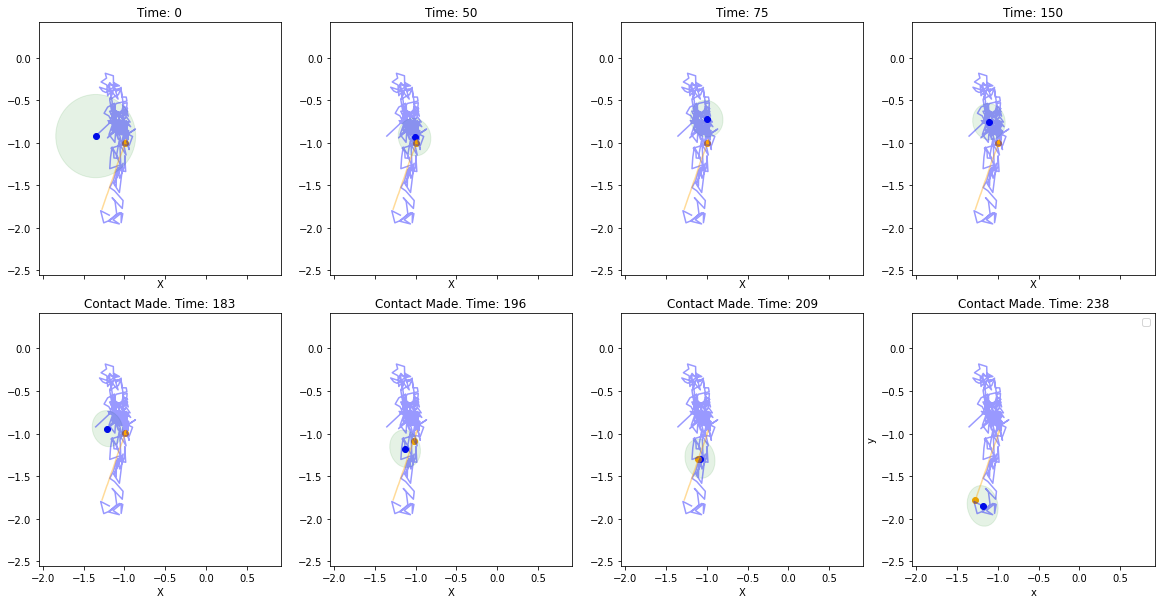

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 0.00685032 -0.00055205]
 [-0.00055205  0.00880917]]
176
15


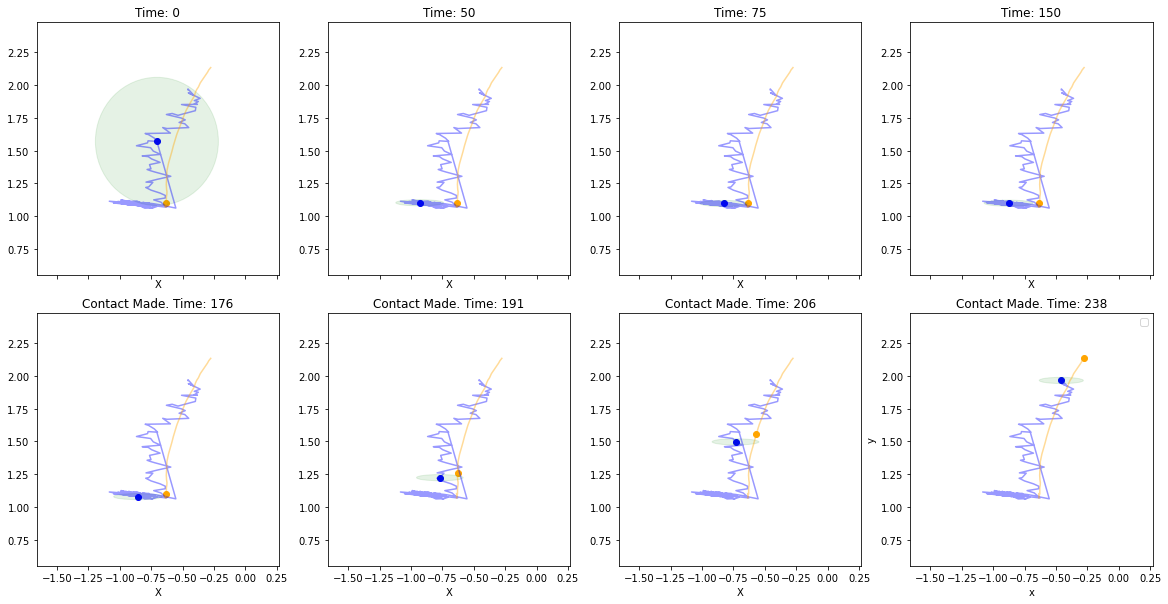

[[ 6.1574685e-03 -1.1618004e-05]
 [-1.1618004e-05  2.5926062e-04]]


In [16]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

In [13]:
name = "ekfmixed_measmse_Q"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, load_checkpoint="phase_3_e2e")


print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))



[buddy-ekfmixed_measmse_Q] Using device: cuda
[buddy-ekfmixed_measmse_Q] Loaded metadata: {'batch': 128, 'ekf_loss': 'mixed', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'measurement_loss': 'mse', 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmixed_measmse_Q] Available checkpoint labels: ['0000000000041379', '0000000000047204', '0000000000047759', '0000000000048330', '0000000000048875', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFi


rsme x: 
0.630639105094193 
 y:
0.2982392400107851
Sigma average:  [[0.19112757 0.00111971]
 [0.00111971 0.03469474]]


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


183
13


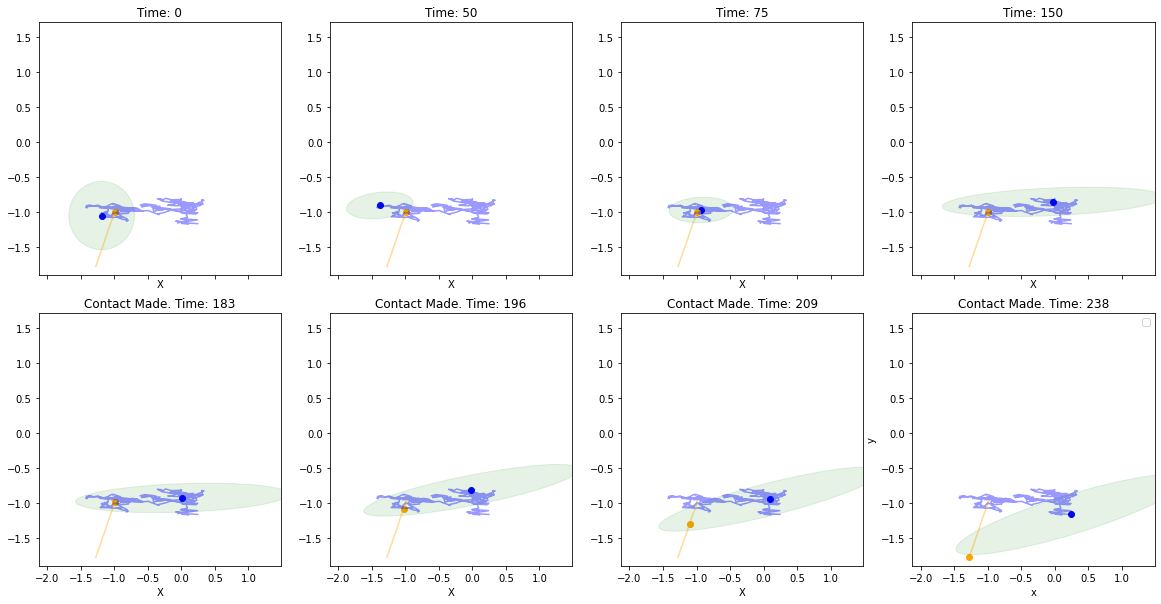

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[0.2662963  0.02856606]
 [0.02856606 0.01384406]]
176
15


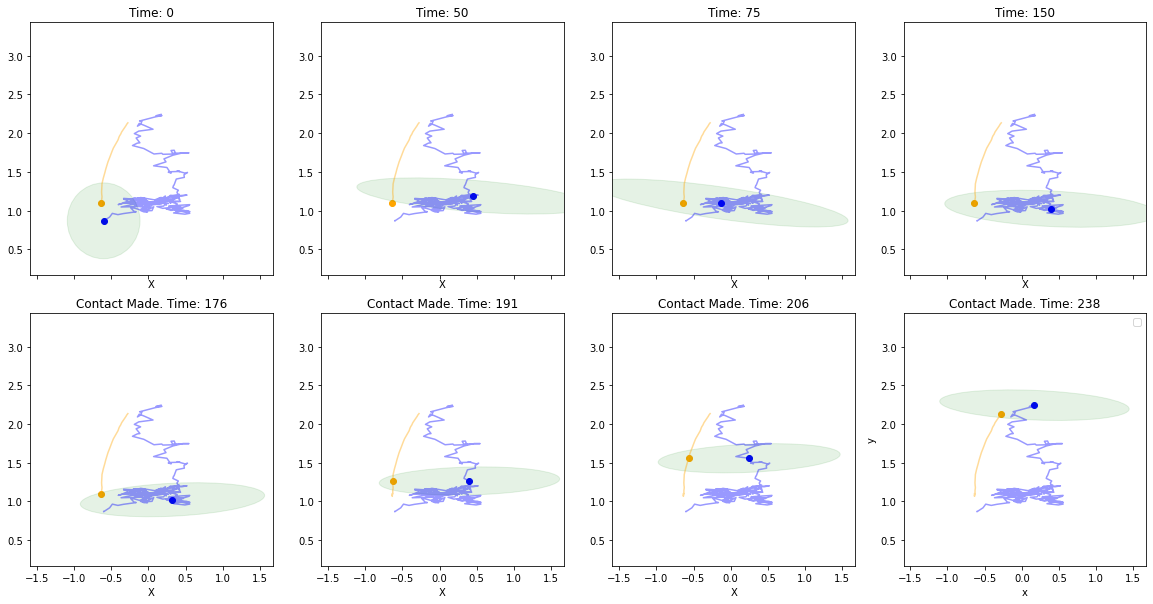

[[ 0.35332504 -0.0247808 ]
 [-0.0247808   0.01143361]]


In [14]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

In [23]:
name = "ekfmse_measmse"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, load_checkpoint="phase_3_e2e")
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))


[buddy-ekfmse_measmse] Using device: cuda
[buddy-ekfmse_measmse] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': False, 'learnable_Q_dynamics': False, 'measurement_nll': False, 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_measmse] Available checkpoint labels: ['0000000000047432', '0000000000047815', '0000000000048201', '0000000000048586', '0000000000048875', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_


rsme x: 
0.3804611402958501 
 y:
0.20026576433376092
Sigma average:  [[0.01150182 0.00088629]
 [0.00088629 0.00376657]]


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


183
13


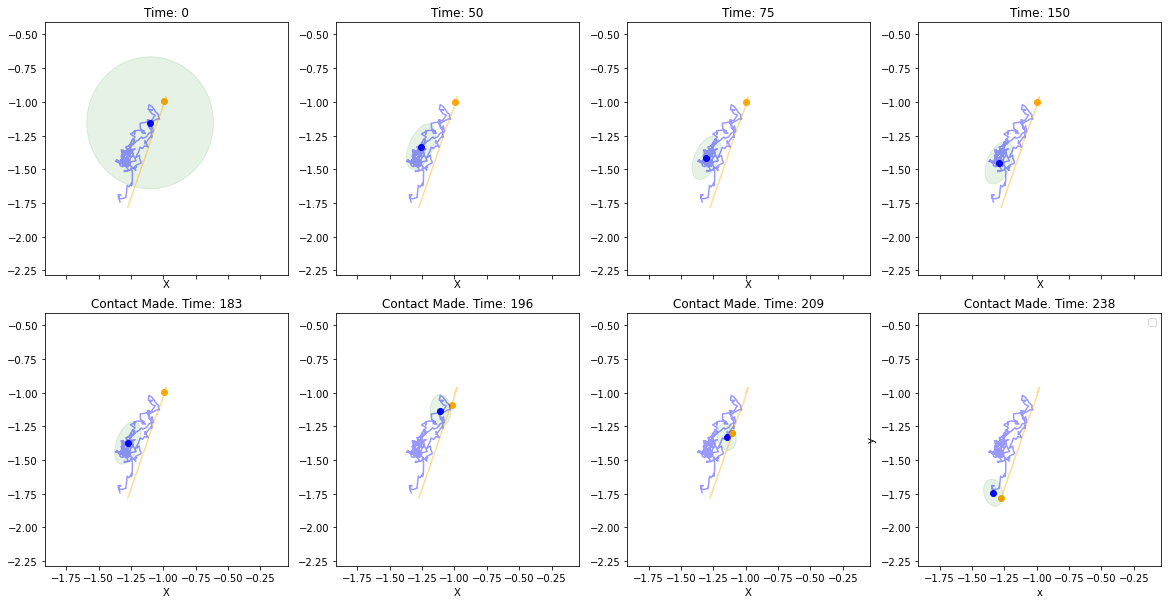

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[0.00244146 0.00124778]
 [0.00124778 0.00482336]]
176
15


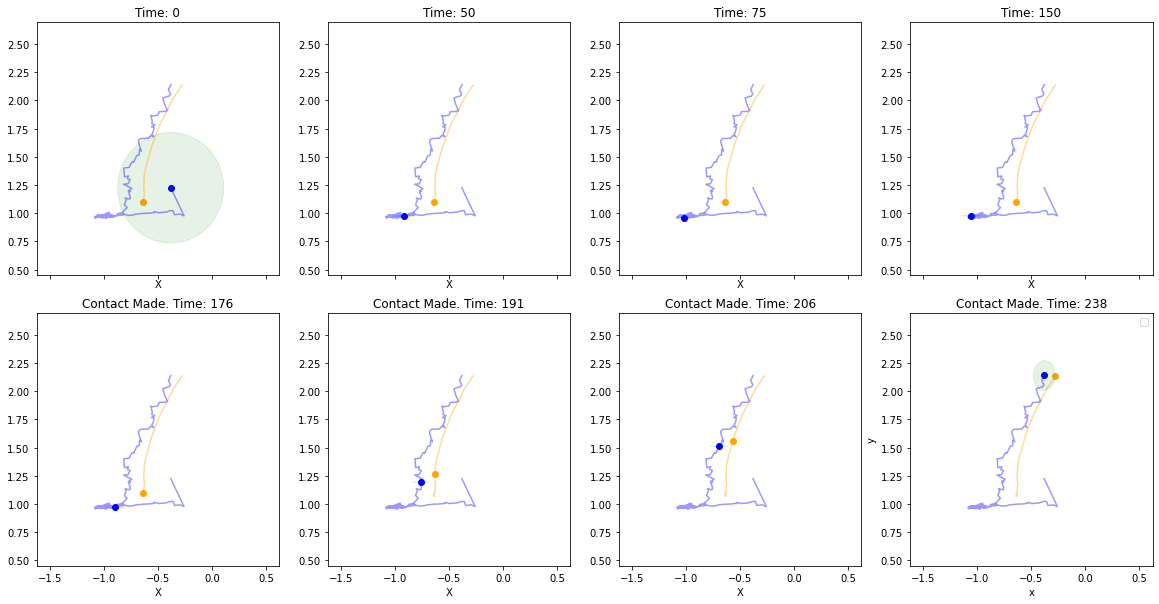

[[2.0229700e-03 1.2685045e-06]
 [1.2685045e-06 3.1962959e-04]]


In [20]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

In [22]:
name = "ekfmse_measmse_Qlearned"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, 
                    load_checkpoint="phase_2_measurement_pretrain")
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))


[buddy-ekfmse_measmse_Qlearned] Using device: cuda
[buddy-ekfmse_measmse_Qlearned] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'measurement_nll': False, 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_measmse_Qlearned] Available checkpoint labels: ['0000000000047216', '0000000000047675', '0000000000048193', '0000000000048736', '0000000000048875', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[Tr


rsme x: 
0.7472752556708532 
 y:
0.6920390282931584
Sigma average:  [[ 1.3702551e-02 -7.9722849e-05]
 [-7.9722849e-05  6.6889129e-03]]


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


183
13


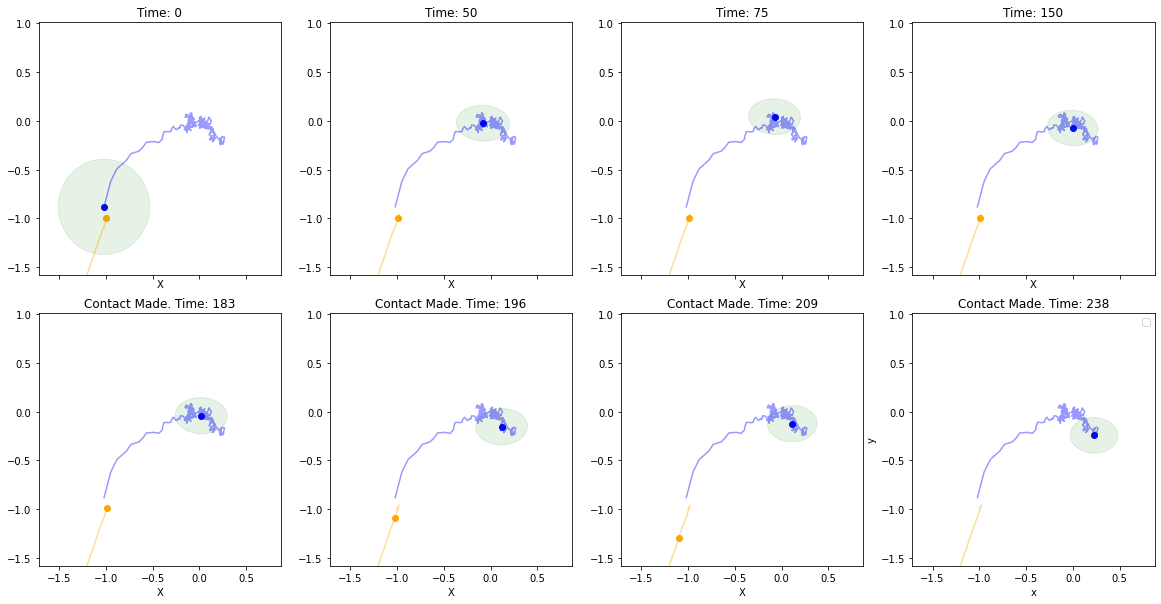

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 0.01367815 -0.00026634]
 [-0.00026634  0.0062526 ]]
176
15


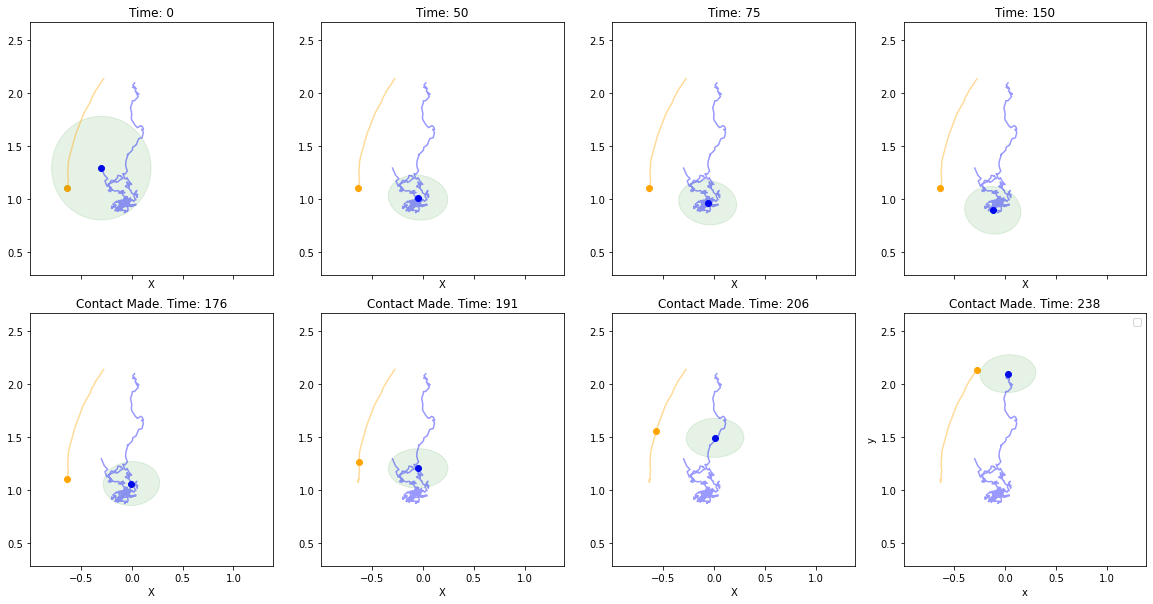

[[ 0.01473612 -0.00037709]
 [-0.00037709  0.00791332]]


In [10]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

[buddy-ekfnll_measnll_Qlearned] Using device: cuda
[buddy-ekfnll_measnll_Qlearned] Loaded metadata: {'batch': 128, 'ekf_loss': 'nll', 'epochs': 15, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'measurement_nll': True, 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'all', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfnll_measnll_Qlearned] Available checkpoint labels: ['0000000000045512', '0000000000047474', '0000000000047957', '0000000000048537', '0000000000048875', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[Tra


rsme x: 
0.41106510939885454 
 y:
0.5500171667633453
183
13


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


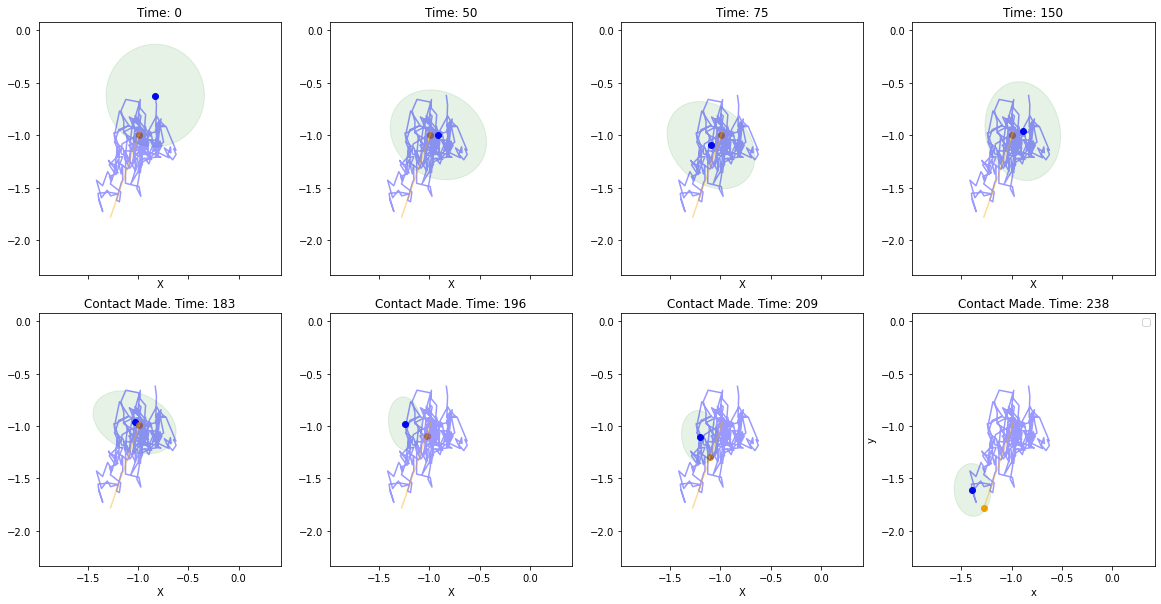

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 0.02347855 -0.00364194]
 [-0.00364194  0.02575735]]
176
15


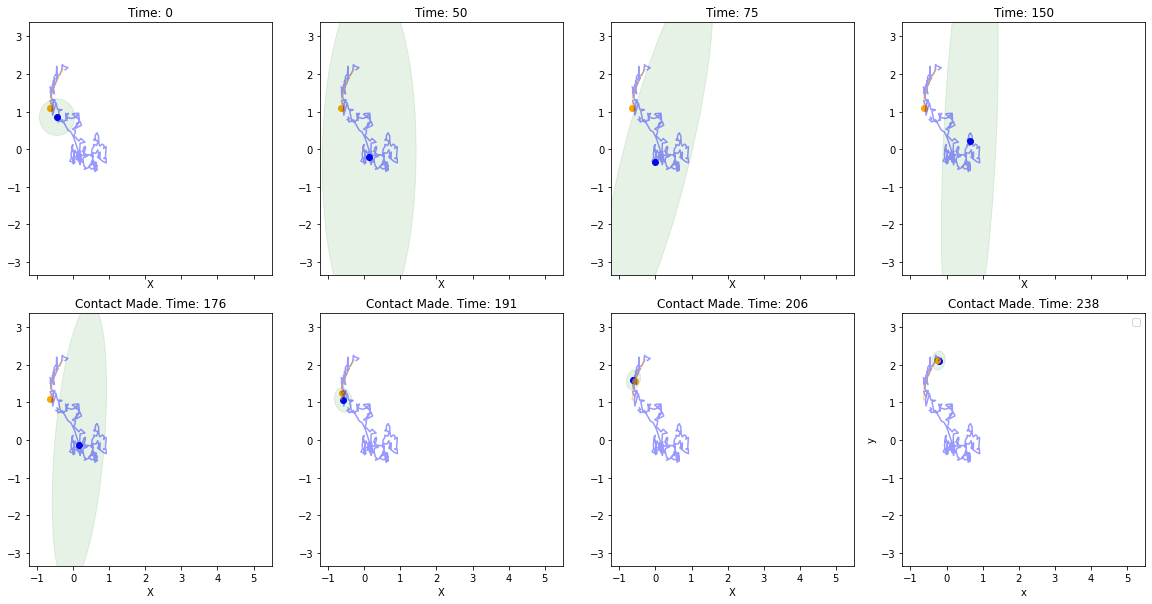

[[0.14808422 0.11430705]
 [0.11430705 2.692294  ]]


In [24]:
name = "ekfnll_measnll_Qlearned"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, 
                                                     load_checkpoint="phase_3_e2e")
# print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))

for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


183
13


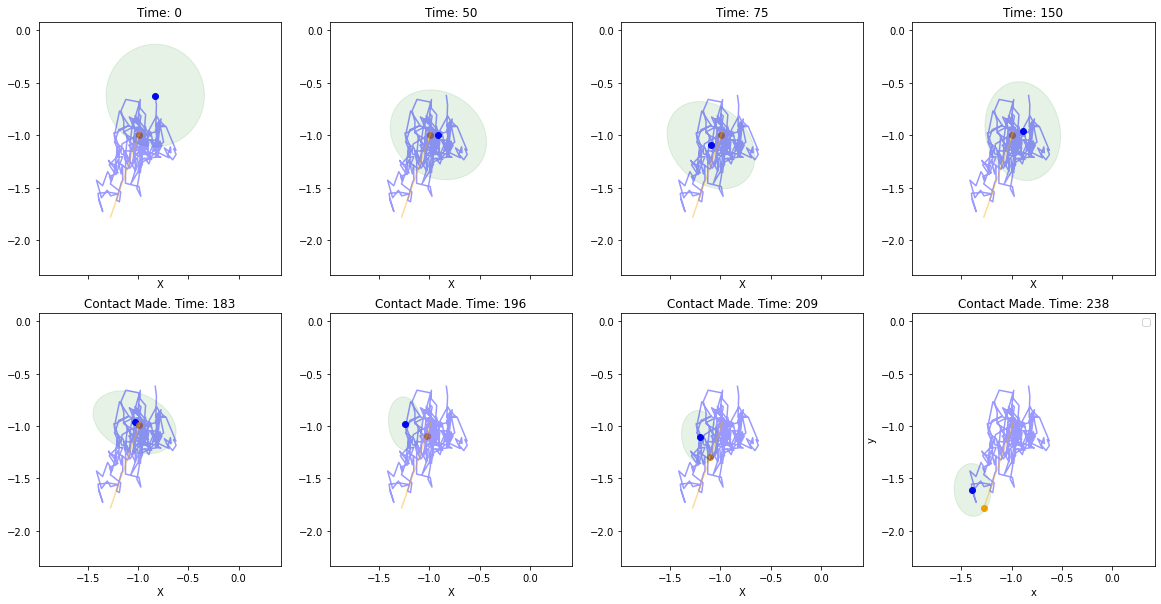

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


176
15


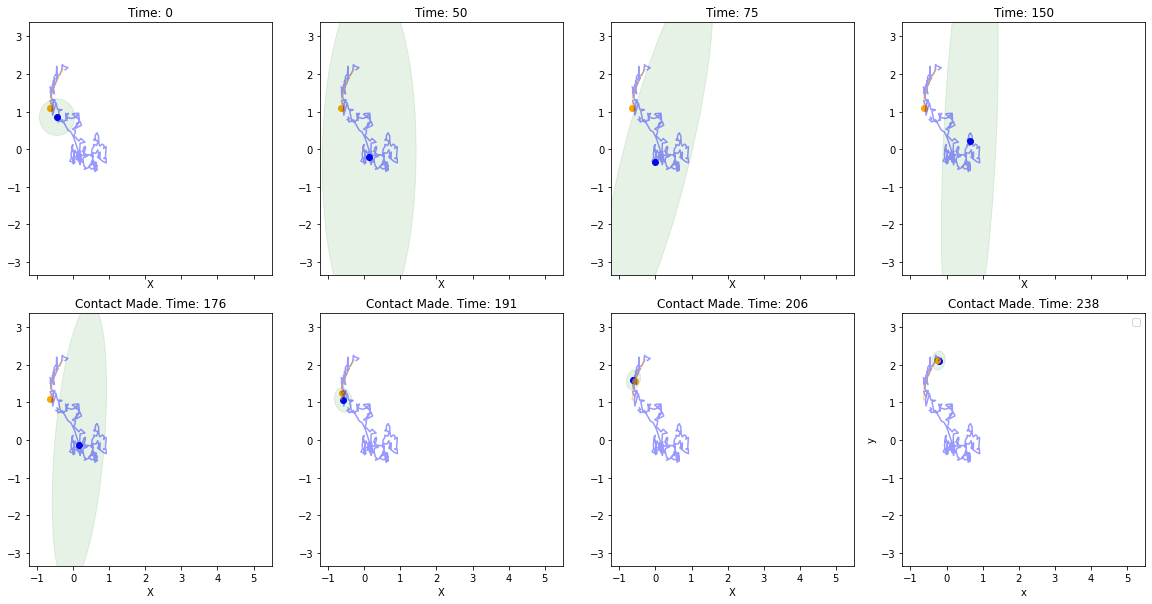

In [25]:
for i in range(2):
    
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])